# Basics of Dask
## Three fundamental types of Data Structures in Dask
1. Array
2. Dataframe
3. Bag

In [1]:
print("hello world")

hello world


In [19]:
# 1. Arrays
import dask.array as da
import numpy as np
x = np.arange(10000).reshape(200, 50) # Create a NumPy array
# Convert to Dask array with specified chunk size, so each chunk is a 100x100 block created from 2000x5 NumPy array
# Dask array is a parallel, larger-than-memory array
x = da.from_array(x, chunks=(100, 25))
# NOTE : chunk size is always lesser than or equal to the original array size in either dimensions. It is never greater
x

dask.array<array, shape=(200, 50), dtype=int64, chunksize=(100, 25), chunktype=numpy.ndarray>

In [22]:
# We can inspect the chunks. WE have divided the array of 200x50 into  4 chunks of 100x25
# The chunks are stored in a list of tuples, where each tuple represents the shape of the chunk
print(x.chunks)

((100, 100), (25, 25))


In [27]:
print(x.size) # Total number of elements in the array
print(x.nbytes) # Total number of bytes in the array
print(x.shape) # Shape of the array
print(x.dtype) # Data type of the array
print(x.npartitions) # Number of partitions in the array
print(x.numblocks) # Number of blocks in the array

print(x.visualize()) # Visualize the array
print(x.compute()) # Compute the array
print(x.ndim) # This is a 2D Array
# We are free to split in whichever dimensions that we want

10000
80000
(200, 50)
int64
4
(2, 2)
<IPython.core.display.Image object>
[[   0    1    2 ...   47   48   49]
 [  50   51   52 ...   97   98   99]
 [ 100  101  102 ...  147  148  149]
 ...
 [9850 9851 9852 ... 9897 9898 9899]
 [9900 9901 9902 ... 9947 9948 9949]
 [9950 9951 9952 ... 9997 9998 9999]]
2


In [36]:
# We can access particular blocks
import matplotlib_inline
print(x.blocks.shape)
print(x.blocks.size)
x.blocks.ravel() # This will give us a 1D array of all the blocks

(2, 2)
4


[dask.array<blocks, shape=(100, 25), dtype=int64, chunksize=(100, 25), chunktype=numpy.ndarray>,
 dask.array<blocks, shape=(100, 25), dtype=int64, chunksize=(100, 25), chunktype=numpy.ndarray>,
 dask.array<blocks, shape=(100, 25), dtype=int64, chunksize=(100, 25), chunktype=numpy.ndarray>,
 dask.array<blocks, shape=(100, 25), dtype=int64, chunksize=(100, 25), chunktype=numpy.ndarray>]

In [38]:
x.blocks[0,0] # This will give us the first block
x.blocks[0,1] # This will give us the second block

dask.array<blocks, shape=(100, 25), dtype=int64, chunksize=(100, 25), chunktype=numpy.ndarray>

In [42]:
# Slicing requires us to actually compute to be able to use
fetched_rows = x.blocks[0,1][30:65, 15] # This will give us the second block and get specific elements of the block and it will fetch us rows 30 to 65 and 15th column

print(fetched_rows)
# But to actually print them, instead of getting the reference to the block, we have to compute it 
fetched_rows.compute()

dask.array<getitem, shape=(35,), dtype=int64, chunksize=(35,), chunktype=numpy.ndarray>


array([1540, 1590, 1640, 1690, 1740, 1790, 1840, 1890, 1940, 1990, 2040,
       2090, 2140, 2190, 2240, 2290, 2340, 2390, 2440, 2490, 2540, 2590,
       2640, 2690, 2740, 2790, 2840, 2890, 2940, 2990, 3040, 3090, 3140,
       3190, 3240])

In [44]:
# Let us compute mean
mean = fetched_rows.mean().compute()
print(mean)
np.sin(fetched_rows).compute() # This will compute the sine of the fetched rows

2390.0


array([ 5.80709352e-01,  3.46762554e-01,  8.85188172e-02, -1.75927251e-01,
       -4.28046459e-01, -6.50173331e-01, -8.26743896e-01, -9.45386217e-01,
       -9.97787270e-01, -9.80275421e-01, -8.94077690e-01, -7.45233775e-01,
       -5.44172862e-01, -3.04982875e-01, -4.44233664e-02,  2.19248797e-01,
        4.67558647e-01,  6.83107625e-01,  8.50792657e-01,  9.58864398e-01,
        9.99750482e-01,  9.70586107e-01,  8.73414759e-01,  7.15045037e-01,
        5.06573579e-01,  2.62607552e-01,  2.41154825e-04, -2.62142140e-01,
       -5.06157674e-01, -7.14707781e-01, -8.73179784e-01, -9.70469876e-01,
       -9.99761140e-01, -9.59001197e-01, -8.51046013e-01])

In [50]:
# Take Transpose of the Rows
fetched_rows = fetched_rows.reshape(7, 5)
fetched_rows.T.compute()

array([[1540, 1790, 2040, 2290, 2540, 2790, 3040],
       [1590, 1840, 2090, 2340, 2590, 2840, 3090],
       [1640, 1890, 2140, 2390, 2640, 2890, 3140],
       [1690, 1940, 2190, 2440, 2690, 2940, 3190],
       [1740, 1990, 2240, 2490, 2740, 2990, 3240]])

In [53]:
print(fetched_rows.max(axis=0).compute()) # This will compute the median of the fetched rows along the 0th axis 
print(fetched_rows.max(axis=1).compute()) # This will compute the median of the fetched rows along the 1st axis

[3040 3090 3140 3190 3240]
[1740 1990 2240 2490 2740 2990 3240]


In [61]:
print(fetched_rows.mean().compute())
# fetched_rows.median().compute()
# fetched_rows.std(axis=0).compute()

2390.0


In [ ]:
# Now, let us see how the original array gets transformed and where it starts from. Each layer represents a step in the transformation from original static declarations
fetched_rows.dask

HighLevelGraph with 4 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x77e4c69143e0>
 0. array-5c99b8054449ebae761fde2e073fb3ab
 1. blocks-27886b6a29c7ea9374d8127d1c1dc460
 2. getitem-2edec0a42186e4a48ed764c76ded7bd0
 3. reshape-20cd5d97f0fc48a8a620f7dc6528acec

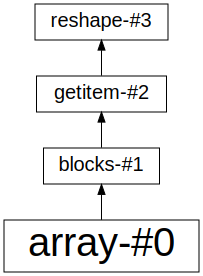

In [63]:
fetched_rows.dask.visualize() # This will visualize the graph of the computation

In [73]:
# 2. DataFrames
import dask.dataframe as dd
import pandas as pd
# Create a Pandas DataFrame
index = pd.date_range("2023-01-01", periods=2400, freq="1h")
original_df = pd.DataFrame({"a": np.arange(2400), "b": list("abcaddbe" * 300)}, index=index)
ddf = dd.from_pandas(original_df, npartitions=4) # Convert to Dask DataFrame with 4 partitions
# Dask DataFrame is a parallel, larger-than-memory DataFrame
# We can inspect the partitions
print(ddf.npartitions) # Number of partitions in the DataFrame
print(ddf.divisions) # Divisions of the DataFrame
print(ddf.shape) # Shape of the DataFrame
print(ddf.columns) # Columns of the DataFrame
    
print(ddf) # This will give us the first 15 rows of the DataFrame

4
(Timestamp('2023-01-01 00:00:00'), Timestamp('2023-01-26 00:00:00'), Timestamp('2023-02-20 00:00:00'), Timestamp('2023-03-17 00:00:00'), Timestamp('2023-04-10 23:00:00'))
(<dask_expr.expr.Scalar: expr=df.size() // 2, dtype=int64>, 2)
Index(['a', 'b'], dtype='object')
Dask DataFrame Structure:
                         a       b
npartitions=4                     
2023-01-01 00:00:00  int64  string
2023-01-26 00:00:00    ...     ...
2023-02-20 00:00:00    ...     ...
2023-03-17 00:00:00    ...     ...
2023-04-10 23:00:00    ...     ...
Dask Name: frompandas, 1 expression
Expr=df


In [74]:
# Access Partitions 
# len(ddf.partitions)
subpart = ddf.partitions[2] # This will give us the first partition of the DataFrame
print(subpart)
subpart.compute() # This will compute the partition
print(subpart.shape) # Shape of the partition
print(subpart.columns) # Columns of the partition

Dask DataFrame Structure:
                   a       b
npartitions=1               
2023-02-20     int64  string
2023-03-17       ...     ...
Dask Name: partitions, 2 expressions
Expr=Partitions(frame=df, partitions=[2])
(<dask_expr.expr.Scalar: expr=(Partitions(frame=df, partitions=[2])).size() // 2, dtype=int64>, 2)
Index(['a', 'b'], dtype='object')


In [ ]:
# Indexing through the index as column names and also entries
print(ddf.b)
ddf.b[0:5] # This will give us the first 5 rows of the DataFrame as computational lazy graph

Dask Series Structure:
npartitions=4
2023-01-01 00:00:00    string
2023-01-26 00:00:00       ...
2023-02-20 00:00:00       ...
2023-03-17 00:00:00       ...
2023-04-10 23:00:00       ...
Dask Name: getitem, 2 expressions
Expr=df['b']


Dask Series Structure:
npartitions=1
1970-01-01 00:00:00.000000000    string
1970-01-01 00:00:00.000000005       ...
Dask Name: loc, 3 expressions
Expr=LocSlice(frame=df['b'], iindexer=slice(0, 5, None))

In [84]:
original_data = ddf["2023-01-26 00:00:00": "2023-01-26 08:00:00"] # Time interval of every one hour
print(original_data)
original_data.compute()

Dask DataFrame Structure:
                                   a       b
npartitions=1                               
2023-01-26 00:00:00.000000000  int64  string
2023-01-26 08:00:00.999999999    ...     ...
Dask Name: loc, 2 expressions
Expr=LocSlice(frame=df, iindexer=slice(Timestamp('2023-01-26 00:00:00'), Timestamp('2023-01-26 08:00:00.999999999'), None))


,a,b
2023-01-26 00:00:00,600,a
2023-01-26 01:00:00,601,b
2023-01-26 02:00:00,602,c
2023-01-26 03:00:00,603,a
2023-01-26 04:00:00,604,d
2023-01-26 05:00:00,605,d
2023-01-26 06:00:00,606,b
2023-01-26 07:00:00,607,e
2023-01-26 08:00:00,608,a


In [ ]:
print(subpart.compute().shape) # Remember we have to first compute the subpart. Only then we can actually gets numerical value for its shape
print(subpart.a.mean().compute())
print(subpart.a.median().compute())
print(subpart.a.std().compute())
print(subpart.a.max().compute())
print(subpart.b.unique().compute())
print(subpart.b.value_counts().compute())

(600, 2)
1499.5
1499.5
173.34935823359717
1799
0    a
1    b
2    c
3    d
4    e
Name: b, dtype: string
b
a    150
b    150
c     75
d    150
e     75
Name: count, dtype: int64[pyarrow]


In [94]:
subpart.compute().tail()

,a,b
2023-03-16 19:00:00,1795,a
2023-03-16 20:00:00,1796,d
2023-03-16 21:00:00,1797,d
2023-03-16 22:00:00,1798,b
2023-03-16 23:00:00,1799,e


In [98]:
result = subpart.a.cumsum() - 100
print(result) # This will compute the cumulative sum of the column a and subtract 100 from it

Dask Series Structure:
npartitions=1
2023-02-20    int64
2023-03-17      ...
Dask Name: sub, 5 expressions
Expr=CumSum(frame=(Partitions(frame=df, partitions=[2]))['a'], skipna=True) - 100


In [99]:
# Let us now visualize the graph
result.dask

{('sub-66d7966c7d8db2830970ecb0b2a86b1e',
  0): <Task ('sub-66d7966c7d8db2830970ecb0b2a86b1e', 0) sub(...)>,
 ('cumulativefinalize-24d5e3c760b3061cbdebd4c9104fe1de',
  0): ('cumsum-9f12b19788f44f589c1ea9694b6ac544', 0),
 ('operation-7ae87abefad03e8a455b0c711012214a',
  0): <Task ('operation-7ae87abefad03e8a455b0c711012214a', 0) operation(...)>,
 ('cumsum-9f12b19788f44f589c1ea9694b6ac544',
  0): <Task ('cumsum-9f12b19788f44f589c1ea9694b6ac544', 0) cumsum(...)>,
 ('getitem-08282f06fbd47f6f090d934f4685e74e',
  0): <Task ('getitem-08282f06fbd47f6f090d934f4685e74e', 0) getitem(...)>,
 ('partitions-5da0492c32ea3f6b8826c2d319dca493',
  0): Alias(('partitions-5da0492c32ea3f6b8826c2d319dca493', 0)->('frompandas-6dfcffee2a6e533c92038c8fc476d779', 2)),
 ('frompandas-6dfcffee2a6e533c92038c8fc476d779',
  0):                        a  b
 2023-01-01 00:00:00    0  a
 2023-01-01 01:00:00    1  b
 2023-01-01 02:00:00    2  c
 2023-01-01 03:00:00    3  a
 2023-01-01 04:00:00    4  d
 ...                

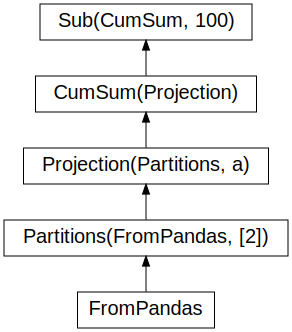

In [101]:
result.visualize()

In [102]:
print(result.compute())

2023-02-20 00:00:00      1100
2023-02-20 01:00:00      2301
2023-02-20 02:00:00      3503
2023-02-20 03:00:00      4706
2023-02-20 04:00:00      5910
                        ...  
2023-03-16 19:00:00    892410
2023-03-16 20:00:00    894206
2023-03-16 21:00:00    896003
2023-03-16 22:00:00    897801
2023-03-16 23:00:00    899600
Freq: h, Name: a, Length: 600, dtype: int64
